In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Imputer, LabelBinarizer, Normalizer, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb

In [2]:
# 检查列缺失值，返回缺失值百分比的字典
def check_nan(df_var, show=True):
    print(df_var.shape)
    nan_result = df_var.isnull().sum(axis=0)
    col_name_list = df_var.columns.values
    result_dict = {k: v for k, v in zip(col_name_list, list(nan_result))}

    total = df_var.shape[0]
    
    nan_dict = dict()
    
    print("含有缺失值的列为：")
    for rd in result_dict.items():
        if rd[1] != 0:
            if show:
                print("{}: {}%".format(rd[0], round((rd[1]/total)*100, 2)))
            nan_dict[rd[0]] = round((rd[1]/total)*100, 2)

    return nan_dict

# 箱线图 连续类型特征（多选），枚举类型特征（单选）
def draw_box(df, value_fields=None, y_col=None, have_y=False):

    for value_field in value_fields:
        # data = pd.concat([df[value_field], df[y_col]], axis=1)
        plt.subplots(figsize=(15, 12))
        if have_y:
            fig = sns.boxplot(x=df[y_col], y=value_field, data=df)
        else:
            fig = sns.boxplot(x=None, y=value_field, data=df)
        plt.xlabel(y_col, fontdict={'weight': 'normal', 'size': 24})
        plt.ylabel(value_field, fontdict={'weight': 'normal', 'size': 24})
        plt.yticks(size=18)
        plt.xticks(size=18)
        fig.axis()
        plt.show()

# 填补缺失值 mean median most_frequent constant
def imputer_nan(df, axis=None, cols=None, missing_values="NaN", strategy='mean', fill_value=0):
    if strategy == "constant":
        if cols:
            part_a = df.drop(cols, axis=axis)
            part_b = df[cols]
            try:
                fill_value = float(fill_value)
            except TypeError:
                pass

            part_b = part_b.fillna(fill_value)
            # 合并
            df = pd.concat([part_a, part_b], axis=axis)
        else:
            df = df.fillna(fill_value)
    else:
        imp = Imputer(missing_values=missing_values, strategy=strategy)
        try:
            if cols:
                part_a = df.drop(cols, axis=axis)
                part_b = df[cols]
                if "object" in str(part_b.dtypes):
                    print("is object")
                part_b_name_list = part_b.columns.values
                part_b = imp.fit_transform(part_b)
                part_b = pd.DataFrame(part_b, columns=part_b_name_list)
                # 合并
                df = pd.concat([part_a, part_b], axis=axis)
            else:
                col_name_list = df.columns.values
                df = imp.fit_transform(df)
                df = pd.DataFrame(df, columns=col_name_list)
        except ValueError as e:
            print("部分列中存在多种类型的数据，请先转哑变量后再填充")
            raise e

    return df

# xgboost分类
def xgboost_classifier(x, y, max_depth=3, learning_rate=0.1, n_estimators=100, min_child_weight=1, gamma=0,
                                  subsample=1, colsample_bytree=1, scale_pos_weight=1, random_state=27, reg_alpha=0, reg_lambda=1):

    if max_depth:
        max_depth = int(max_depth)
        if max_depth < 0:
            max_depth = None
    else:
        max_depth = None

    learning_rate = float(learning_rate)
    n_estimators = int(n_estimators)
    min_child_weight = int(min_child_weight)
    gamma = float(gamma)
    subsample = float(subsample)
    colsample_bytree = float(colsample_bytree)
    scale_pos_weight = int(scale_pos_weight)

    random_state = int(random_state)

    # 拟合XGBoost模型
    model = xgboost.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
                                  min_child_weight=min_child_weight, gamma=gamma,
                                  subsample=subsample, colsample_bytree=colsample_bytree,
                                  scale_pos_weight=scale_pos_weight, random_state=random_state, reg_alpha=reg_alpha, reg_lambda=reg_lambda)

    model.fit(x, y)
    return model

# 划分训练集和测试集
def split_train_test(df, random_state=33, test_size=0.25):
    random_state = int(random_state)
    test_size = float(test_size)
    train, test = train_test_split(df, random_state=random_state, test_size=test_size)
    return train, test

def split_column(df, y="y"):
    try:
        X = df.drop(y, axis=1)
    except KeyError:
        raise KeyError("请在拆分列的参数中选择数据中有的字段")
    y = pd.DataFrame(df[y], columns=[y])
    return X, y


# 删除列
def delete_column(df, target=None, inverse=False):
    # 默认值
    if target is None:
        target = []
    # 所有列
    col_name_list = list(df.columns.values)
    # 两种情况
    if inverse:
        for t in target:
            col_name_list.remove(t)
        df = df.drop(col_name_list, axis=1)
    else:
        df = df.drop(target, axis=1)
    return df

# 处理时间格式数据
# 00:00 ==> 3800
# NaN   ==> 0
def tran_date(df_var, field_name):
    date_value = []
    for dlt in df_var[field_name]:
        if not isinstance(dlt, float):
            a, b = dlt.split(":")
            value = float(a) * 60 + float(b)
            date_value.append(3800 - value)
        else:
            date_value.append(0)
    df_var[field_name] = date_value
    return df_var

# 转换为one-hot编码
def OnehotEncoding(df, columns=None):
    if not columns:
        col_name_list = df.columns.values

        obj_list = []
        for index, d in enumerate(df.dtypes):
            if d == "object":
                obj_list.append(col_name_list[index])

        columns = obj_list

    data = df[columns]
    # 实例化OnehotEncoder
    enc = OneHotEncoder(categories="auto")
    # 生成目标特征列One_hot编码
    data_encoded = enc.fit_transform(data).toarray()
    # 生成新的列名
    new_columns = list(enc.get_feature_names())
    for i, column_name in enumerate(new_columns):
        df[column_name] = data_encoded[:, i]
    return df

# 自动分箱分析（卡方分箱，需要标签值，需要选定分成几个箱子）（展示分段）
def Chi_merge(df, x_col=None, y_col=None, k=6, rate=0.4):
    if not x_col:
        x_col = list(df.columns.values)

    pinf = float('inf')  # 正无穷大
    ninf = float('-inf')  # 负无穷大
    df_json = []
    
    bin_dict = dict()
    for col in x_col:
        print(col)
        col_result_dict = {}
        # 读取数据
        data = pd.concat([df[col], df[y_col]], axis=1)

        # 数据统计[feature1, class1, class2, class3]
        df_count = data.groupby(col)[y_col].value_counts().unstack().reset_index()
        df_count.fillna(0, inplace=True)

        # 去掉一些行，用于加快计算速度
        while df_count.shape[0] > 120:
            drop_row_index = []
            threshold = (data.shape[0] / df_count.shape[0]) * rate
            for i in range(df_count.shape[0] - 1):
                diff = 0
                for j in range(df_count.shape[1] - 1):
                    diff = abs(df_count.iloc[i, j + 1] - df_count.iloc[i + 1, j + 1]) + diff
                if diff < threshold:
                    drop_row_index.append(i + 1)
            df_count.drop(drop_row_index, inplace=True)
            len_df_count = df_count.shape[0]
            df_count.index = [i for i in range(len_df_count)]
            # print(len_df_count)

        df_count.index.name = 'index'
        n_class = df_count.shape[1] - 1
        num_interval = df_count.shape[0]
        print("num_interval: ", num_interval)
        max_col = pinf

        # 计算卡方值，合并删除，直到行数为k
        while (num_interval > k):
            chi_values = []
            drop_index = []
            for i in range(num_interval - 1):  # 制作表格，行列分别求和，用于计算卡方值
                data_chi = df_count.iloc[i:i + 2, 1:].copy().reset_index(drop=True)
                data_chi['sum'] = data_chi.apply(lambda x: x.sum(), axis=1)
                data_chi.loc[2] = data_chi.apply(lambda x: x.sum())
                for index in range(2):
                    for j in range(n_class):  # 计算卡方值
                        data_chi.iloc[index, j] = (data_chi.iloc[index, j] -
                                                   data_chi.iloc[index, -1] * data_chi.iloc[2, j] / data_chi.iloc[
                                                       2, -1]) ** 2 / \
                                                  (data_chi.iloc[index, -1] * data_chi.iloc[2, j] / data_chi.iloc[
                                                      2, -1])
                chi_value = sum(data_chi.iloc[0:-1, 0:-1].sum())
                chi_values.append(chi_value)
            min_chi = min(chi_values)  # 最小卡方值
            for i in range(num_interval - 2, -1, -1):  # 合并最小卡方值的行
                if chi_values[i] == min_chi:
                    df_count.iloc[i, 1:] = df_count.iloc[i, 1:] + df_count.iloc[i + 1, 1:]
                    drop_index.append(i + 1)
            df_count.drop(drop_index, inplace=True)  # 丢弃最小卡方值的行
            num_interval = df_count.shape[0]
            df_count.index = [i for i in range(num_interval)]
            df_count.iloc[0, 0] = ninf

        binning_list = list(df_count[col])
        binning_list.remove(binning_list[0])
        print(binning_list)
        
        bin_dict[col] = binning_list
    return bin_dict


def train_and_valid(train_x, train_y, valid_x, valid_y, n_estimators=88, max_depth=8, gamma=0, learning_rate=0.1, reg_alpha=0, reg_lambda=1, random_state=27):
    # xgboost分类
    xg_model = xgboost_classifier(train_x, train_y, max_depth=max_depth, learning_rate=learning_rate,
                                  n_estimators=n_estimators, min_child_weight=1, gamma=gamma,
                                  subsample=1, colsample_bytree=1, scale_pos_weight=1,
                                  random_state=random_state, reg_alpha=reg_alpha, reg_lambda=reg_lambda)  
    y_pred = xg_model.predict(valid_x)

    accuracy_score_result = metrics.accuracy_score(valid_y, y_pred)
    precision_score_result = metrics.precision_score(valid_y, y_pred, average='macro')
    recall_score_result = metrics.recall_score(valid_y, y_pred, average='macro')
    f1_score_result = metrics.f1_score(valid_y, y_pred, average='macro')

#     print("accuracy_score_result: {}".format(accuracy_score_result))
#     print("precision_score_result: {}".format(precision_score_result))
#     print("recall_score_result: {}".format(recall_score_result))
#     print("f1_score_result: {}".format(f1_score_result))
    
    return xg_model

# 数据类别
def check_columns_classifier(df, x_list):
    col_name_list = x_list
    classifier_list = []
    for i, name in enumerate(col_name_list):
        name_sum = df[name].value_counts().shape[0]
        classifier_list.append(name_sum)

    result_dict = {k: v for k, v in zip(col_name_list, classifier_list)}
    for rd in result_dict.items():
        print(rd)
    return None

In [3]:
# 读取数据
df_train = pd.read_csv("data/train.csv", low_memory=False)
df_train_label = pd.read_csv("data/train_label.csv", low_memory=False)
df_test = pd.read_csv("data/test.csv", low_memory=False)

In [ ]:
path = "/Users/nick/Documents/dataset/企业失信大赛/复赛/失信企业预测-update20200320"
df_train = pd.read_csv(os.path.join(path, "train_stage2_update_20200320.csv"))
df_train_label = pd.read_csv("data/train_label.csv", low_memory=False)
df_test = pd.read_csv(os.path.join(path, "test_stage2_update_20200320.csv"))

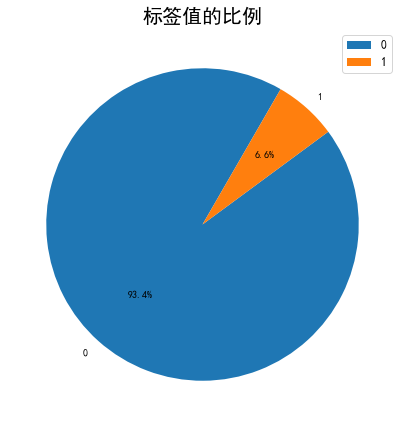

In [4]:
# 类别分析(分析分类的占比的分布)
def check_classifier(df, col_name="Y"):
    result = df[col_name].value_counts()
    cols = result.index
    result_dict = {k: round(v/result.shape[0], 2) for k, v in zip(cols, list(result))}
    
    kinds = []
    nums = []
    for rd in result_dict.items():
        kinds.append(rd[0])
        nums.append(rd[1])
    
    plt.figure(figsize=(7,8))
    plt.pie(nums, labels=kinds, autopct="%3.1f%%", startangle=60)
    plt.title("标签值的比例", fontsize=20)
    plt.legend(fontsize=12)
    plt.show()
    return None

# 查看标签值的比例
_ = check_classifier(df_train_label, col_name="Label")

In [5]:
def check_row_nan_count(df_var, ds_type):
    row_null = df_var.isnull().sum(axis=1)
    row_null_df = pd.DataFrame(df_var["ID"])
    row_null_df["行缺失值数量"] = row_null

    total_columns = df_var.shape[1]
    row_null_df["行缺失值比例"] = round(row_null_df["行缺失值数量"]/total_columns, 2)
    row_null_df_groupby = row_null_df["行缺失值数量"].value_counts()
    data = {
        "行缺失值数量": row_null_df_groupby.index,
        "缺失数量对应的条数": row_null_df_groupby.values
    }
    row_null_df_groupby = pd.DataFrame(data)
    row_null_df_groupby["缺失数量对应的占比"] = round(row_null_df_groupby["缺失数量对应的条数"] / df_var.shape[0], 3)
    row_null_df_groupby = row_null_df_groupby.sort_values(by="行缺失值数量" , ascending=False)
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 6))

    # Plot the crashes where alcohol was involved
    sns.set_color_codes("muted")
    sns.barplot(x="行缺失值数量", y="缺失数量对应的占比", data=row_null_df_groupby,
                label="行缺失值数量", color="b")

    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(xlim=(0, 24), ylabel="",
           xlabel="{}-不同缺失值数量的占比条数".format(ds_type))
    sns.despine(left=True, bottom=True)
    return row_null_df

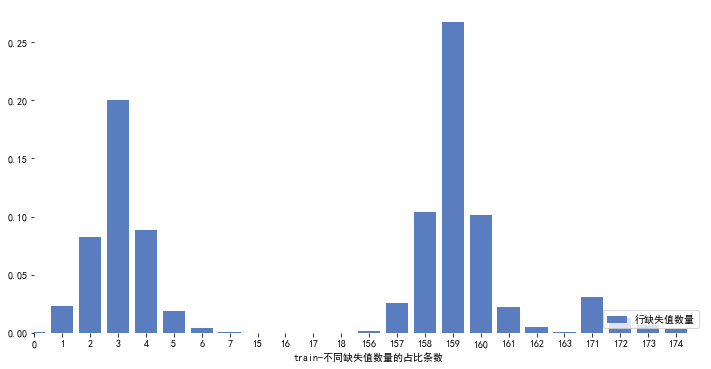

In [6]:
# 分析行缺失比例
row_null_df_train = check_row_nan_count(df_train, "train")

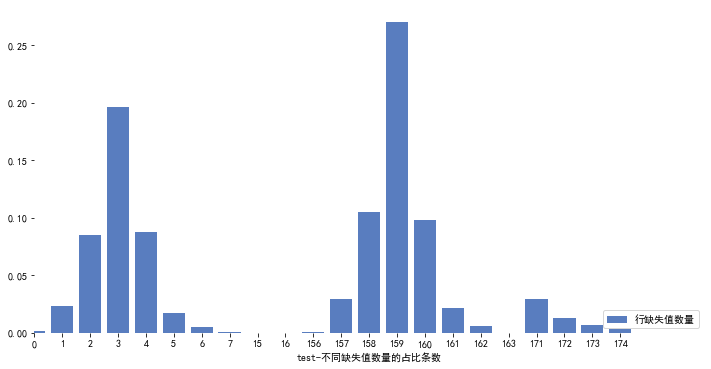

In [7]:
row_null_df_test = check_row_nan_count(df_test, "test")

In [8]:
# 新增特征：行缺失值数量，训练集Y标签字段
df_train["row_null_count"] = row_null_df_train["行缺失值数量"]
df_train["Y"] = df_train_label["Label"]

df_test["row_null_count"] = row_null_df_test["行缺失值数量"]
df_test["Y"] = -1

df = pd.concat([df_train.assign(is_train = 1),df_test.assign(is_train = 0)]) #合并train和test，并且用is_train进行标记
df.head(5)

,ID,企业类型,经营期限至,登记机关,企业状态,邮政编码,投资总额,注册资本,核准日期,行业代码,注销时间,经营期限自,成立日期,行业门类,企业类别,管辖机关,经营范围,增值税,企业所得税,印花税,教育费,城建税,递延收益_年初数,长期负债合计_年初数,长期借款_年初数,长期应付款_年初数,短期借款_年初数,递延所得税负债_年初数,非流动负债合计_年初数,负债合计_年初数,负债和所有者权益总计_年初数,交易性金融负债_年初数,流动负债合计_年初数,其他非流动负债_年初数,其他负债（或长期负债）_年初数,其他流动负债_年初数,其他应付款_年初数,其他应交款_年初数,实收资本（股本）_年初数,实收资本（或股本）净额_年初数,所有者权益合计_年初数,未分配利润_年初数,小企业_应付利润_年初数,应付福利费_年初数,应付股利_年初数,应付利息_年初数,应付票据_年初数,应付职工薪酬_年初数,应付债券_年初数,应付账款_年初数,预计负债_年初数,应交税费_年初数,一年内到期的非流动负债_年初数,预提费用_年初数,预收款项_年初数,盈余公积_年初数,资本公积_年初数,专项应付款_年初数,递延收益_年末数,长期负债合计_年末数,长期借款_年末数,长期应付款_年末数,短期借款_年末数,递延所得税负债_年末数,非流动负债合计_年末数,负债合计_年末数,负债和所有者权益总计_年末数,交易性金融负债_年末数,流动负债合计_年末数,其他非流动负债_年末数,其他负债（或长期负债）_年末数,其他流动负债_年末数,其他应付款_年末数,其他应交款_年末数,实收资本（股本）_年末数,实收资本（或股本）净额_年末数,所有者权益合计_年末数,未分配利润_年末数,小企业_应付利润_年末数,应付福利费_年末数,应付股利_年末数,应付利息_年末数,应付票据_年末数,应付职工薪酬_年末数,应付债券_年末数,应付账款_年末数,预计负债_年末数,应交税费_年末数,一年内到期的非流动负债_年末数,预提费用_年末数,预收款项_年末数,盈余公积_年末数,资本公积_年末数,专项应付款_年末数,货币资金_年初数,存货_年初数,存货中的原材料_年初数,存货中的周转材料_年初数,长期待摊费用_年初数,长期股权投资_年初数,长期投资合计_年初数,长期应收款_年初数,持有至到期投资_年初数,短期投资_年初数,待摊费用_年初数,递延所得税资产_年初数,非流动资产合计_年初数,工程物资_年初数,固定资产合计_年初数,固定资产净额_年初数,固定资产净值_年初数,固定资产清理_年初数,固定资产原价_年初数,交易性金融资产_年初数,库存商品(产成品)_年初数,开发支出_年初数,可供出售金融资产_年初数,流动资产合计_年初数,其他非流动资产_年初数,其他流动资产_年初数,其他应收款_年初数,生产性生物资产_年初数,商誉_年初数,投资性房地产_年初数,无形资产_年初数,无形资产及其他资产合计_年初数,应收账款_年初数,一年内到期的非流动资产_年初数,油气资产_年初数,应收补贴款_年初数,应收股利_年初数,应收利息_年初数,应收票据_年初数,预付款项_年初数,资产总计_年初数,在建工程_年初数,货币资金_年末数,存货_年末数,存货中的原材料_年末数,存货中的周转材料_年末数,长期待摊费用_年末数,长期股权投资_年末数,长期投资合计_年末数,长期应收款_年末数,持有至到期投资_年末数,短期投资_年末数,待摊费用_年末数,递延所得税资产_年末数,非流动资产合计_年末数,工程物资_年末数,固定资产合计_年末数,固定资产净额_年末数,固定资产净值_年末数,固定资产清理_年末数,固定资产原价_年末数,交易性金融资产_年末数,库存商品(产成品)_年末数,开发支出_年末数,可供出售金融资产_年末数,流动资产合计_年末数,其他非流动资产_年末数,其他流动资产_年末数,其他应收款_年末数,生产性生物资产_年末数,商誉_年末数,投资性房地产_年末数,无形资产_年末数,无形资产及其他资产合计_年末数,应收账款_年末数,一年内到期的非流动资产_年末数,油气资产_年末数,应收补贴款_年末数,应收股利_年末数,应收利息_年末数,应收票据_年末数,预付款项_年末数,资产总计_年末数,在建工程_年末数,row_null_count,Y,is_train
0,1,9.0,NaN,1.0,0.0,266300,19.110000,19.110000,00:00.0,5154.0,NaN,00:00.0,00:00.0,1.0,0.0,1.0,"[1412, 1024, 21375, 15023, 18526, 18789, 17022...",106.039650,0.331552,1.247218,3.181189,7.422776,0.0,0.0,25.110484,0.0,0.0,0.0,25.110484,797.386637,844.162546,0.0,772.276153,0.0,0.0,0.0,106.078436,0.0,50.220972,0.0,46.775910,-3.445063,0.0,0.0,0.0,0.0,125.552431,0.000000,0.0,520.839979,0.0,19.805307,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,585.013852,632.032182,0.0,585.013852,0.0,0.0,0.0,83.123866,0.0,50.220972,0.0,47.018330,-3.202643,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,489.934244,0.0,11.955743,0.0,0.0,0.000000,0.0,0.0,0.0,24.579246,462.290647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.081011,0.0,135.081011,0.0,0.0,0.0,368.329907,0.0,0.0,0.0,0.0,709.081535,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,215.371727,0.0,0.0,0.0,0.0,0.0,2.647788,4.192126,844.162546,0.0,31.416284,229.147518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.128884,0.0,0.0,99.813781,0.0,99.813781,0.0,0.0,0.0,368.329907,0.0,0.0,0.0,0.0,532.218401,0.0,0.0,20.088389,0.0,0.0,0.0,0.0,0.0,142.310005,0.0,0.0,0.0,0.0,0.0,28.122902,1.004419,632.032182,0.0,2,0,1
1,3,11.0,NaN,5.0,0.0,266000,29.154194,19.210446,00:00.0,7214.0,NaN,31:40.0,31:40.0,0.0,2.0,3.0,"[3671, 24856, 13525, 21079, 13219, 13694, 1442...",39.175600,51.244655,0.014363,1.175269,2.742293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158,0,1
2,9,0.0,NaN,3.0,0.0,266000,NaN,19.120045,13:31.0,2110.0,NaN,13:31.0,13:31.0,2.0,0.0,4.0,"[3671, 14394, 23662, 11227, 19205, 15633, 5344...",0.000000,0.000000,0.541067,4.637491,10.060346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [9]:
# 检查离散变量的类别数量
check_columns_classifier(df, ["邮政编码", "经营范围", "登记机关", "管辖机关", "企业状态", "行业门类", "企业类别", "行业代码", "企业类型"])

# 列缺失是否严重
df.loc[df.row_null_count <= 18,'列缺失超过88的数据'] = 0
df.loc[df.row_null_count > 18,'列缺失超过88的数据'] = 1
df = df.drop(["row_null_count"], axis=1)

# 时间处理
df = tran_date(df, "成立日期")
bus_count = []
for d in df["成立日期"]:
    bus_count.append(d)
print("成立日期 MAX:", max(bus_count))

# 经营范围数量
bus_count = []
for d in df["经营范围"]:
    d = eval(d)
    c = len(d)
    bus_count.append(c)
df["经营范围数量"] = bus_count

df = df.reset_index(drop=True)
aptmt_set = set()
for i in range(df.shape[0]):
    v = "{}_{}".format(df["登记机关"][i], df["管辖机关"][i])
    aptmt_set.add(v)

df = df.drop(["注销时间", "核准日期", "经营期限至", "经营期限自"], axis=1)

df = df.drop(["邮政编码", "经营范围", "登记机关", "管辖机关"], axis=1)

('邮政编码', 278)
('经营范围', 8319)
('登记机关', 13)
('管辖机关', 13)
('企业状态', 4)
('行业门类', 20)
('企业类别', 4)
('行业代码', 693)
('企业类型', 84)
成立日期 MAX: 3800.0


In [10]:
nd = check_nan(df)

(23944, 174)
企业类型: 5.27%
企业状态: 5.27%
投资总额: 79.72%
注册资本: 5.34%
行业代码: 5.31%
行业门类: 5.28%
企业类别: 5.27%
增值税: 4.56%
企业所得税: 20.15%
印花税: 9.32%
城建税: 4.02%
递延收益_年初数: 58.14%
长期负债合计_年初数: 58.14%
长期借款_年初数: 58.14%
长期应付款_年初数: 58.14%
短期借款_年初数: 58.14%
递延所得税负债_年初数: 58.14%
非流动负债合计_年初数: 58.14%
负债合计_年初数: 58.14%
负债和所有者权益总计_年初数: 58.14%
交易性金融负债_年初数: 58.14%
流动负债合计_年初数: 58.14%
其他非流动负债_年初数: 58.14%
其他负债（或长期负债）_年初数: 58.14%
其他流动负债_年初数: 58.14%
其他应付款_年初数: 58.14%
其他应交款_年初数: 58.14%
实收资本（股本）_年初数: 58.14%
实收资本（或股本）净额_年初数: 58.14%
所有者权益合计_年初数: 58.14%
未分配利润_年初数: 58.14%
小企业_应付利润_年初数: 58.14%
应付福利费_年初数: 58.14%
应付股利_年初数: 58.14%
应付利息_年初数: 58.14%
应付票据_年初数: 58.14%
应付职工薪酬_年初数: 58.14%
应付债券_年初数: 58.14%
应付账款_年初数: 58.14%
预计负债_年初数: 58.14%
应交税费_年初数: 58.14%
一年内到期的非流动负债_年初数: 58.14%
预提费用_年初数: 58.14%
预收款项_年初数: 58.14%
盈余公积_年初数: 58.14%
资本公积_年初数: 58.14%
专项应付款_年初数: 58.14%
递延收益_年末数: 58.14%
长期负债合计_年末数: 58.14%
长期借款_年末数: 58.14%
长期应付款_年末数: 58.14%
短期借款_年末数: 58.14%
递延所得税负债_年末数: 58.14%
非流动负债合计_年末数: 58.14%
负债合计_年末数: 58.14%
负债和所有者权益总计_年末数: 58.14%
交易性金融负债_年末数

In [11]:
# 离散变量
scatter_fields = ["企业状态", "行业门类", "企业类别", "行业代码", "企业类型"]  # 行业代码
# 资本和投资数据
fill_small_fields = ["投资总额", "注册资本"]
# 几个重要的税值
important_price_fields = ["增值税", "企业所得税", "印花税", "城建税", "教育费"]

# 填充-999
no_continuous_fields = scatter_fields + fill_small_fields + important_price_fields
continuous_fields = []
for n in nd.keys():
    if n in no_continuous_fields:
        pass
    else:
        continuous_fields.append(n)

df = df.reset_index(drop=True)

# mean median most_frequent constant
# 离散变量-填充平均值
df = imputer_nan(df, axis=1, cols=scatter_fields, missing_values="NaN", strategy='constant', fill_value=-1)

# 填充中位数
# df = imputer_nan(df, axis=1, cols=[], missing_values="NaN", strategy='median', fill_value=0)

# 几个重要的税值-填充平均值
df = imputer_nan(df, axis=1, cols=important_price_fields, missing_values="NaN", strategy='mean', fill_value=-999)

# 资本和投资数据-连续变量-填充常量 -999
df = imputer_nan(df, axis=1, cols=fill_small_fields, missing_values="NaN", strategy='constant', fill_value=-999)
df = imputer_nan(df, axis=1, cols=continuous_fields, missing_values="NaN", strategy='constant', fill_value=-999)

is object


In [12]:
nd = check_nan(df)

(23944, 174)


In [13]:
# 重要税值的比值，会有两种情况
# 0/0 => NaN
# constant/0 => inf
# 0/constant => 0
important_price_fields = ["增值税", "企业所得税", "印花税", "城建税", "教育费", "经营范围数量"]

inf = np.inf
nan = np.nan

for index1, f1 in enumerate(important_price_fields):
    for index2, f2 in enumerate(important_price_fields):
        if index2 > index1:
            l_value_list = []
            for index, a in enumerate(df[f1]):
                b = df[f2][index]

                if a == b == 0:
                    value = -999
                elif b ==0 and a > 0:
                    value = 999
                else:
                    value = a / b
                l_value_list.append(value)

            df["{}_{}_比值".format(f1, f2)] = l_value_list


In [14]:
dl_list = ["行业门类", "企业状态", "企业类别", "企业类型"]
df = OnehotEncoding(df, columns=dl_list)
df = df.drop(dl_list, axis=1)

In [15]:
# 训练
df_train = df[df["is_train"] == 1]
df_test = df[df["is_train"] == 0]

df_train = df_train.drop(["ID", "is_train"], axis=1)

df_train_train, df_train_valid = split_train_test(df_train, random_state=15, test_size=0.25)

df_train_train_x, df_train_train_y = split_column(df_train_train, y="Y")
df_train_valid_x, df_train_valid_y = split_column(df_train_valid, y="Y")

df_train.head(30)

model = train_and_valid(df_train_train_x, df_train_train_y, df_train_valid_x, df_train_valid_y)
# 计算y_prob, y_pred
y_prob = model.predict_proba(df_train_valid_x)
# 计算auc, ks, gini
fpr, tpr, threshold = metrics.roc_curve(df_train_valid_y, y_prob[:, 1])
auc_value = metrics.auc(fpr, tpr)  # 计算auc
print("=======", ne, "** auc_value: 【{}】 **".format(auc_value))
    
result_dict = {k: v for k, v in zip(df_train_train_x.columns.values, list(model.feature_importances_))}
dict_list = sorted(result_dict.items(), key=lambda x: x[1], reverse=True)
not_zero_list = []
for dl in dict_list:
    if dl[1] < 0.01:
        not_zero_list.append(dl[0])
    else:
        print(dl)


======= 1 ** auc_value: 【0.9339457615997805】 **
('城建税_教育费_比值', 0.16460319)
('企业所得税', 0.024352634)
('x2_2.0', 0.017834624)
('x3_5.0', 0.016948564)
('企业所得税_经营范围数量_比值', 0.015085417)
('货币资金_年末数', 0.014188451)
('货币资金_年初数', 0.0141638825)
('负债合计_年初数', 0.013977843)
('企业所得税_教育费_比值', 0.013091735)
('所有者权益合计_年初数', 0.012847171)
('预收款项_年末数', 0.012527846)
('x0_3.0', 0.012226314)
('x0_2.0', 0.012060878)
('应付职工薪酬_年初数', 0.011542818)
('企业所得税_城建税_比值', 0.011498085)
('无形资产_年末数', 0.011335134)
('实收资本（股本）_年初数', 0.011220059)
('应收账款_年初数', 0.011069249)
('x3_8.0', 0.011000073)
('x3_11.0', 0.010794633)
('x2_0.0', 0.01061288)
('印花税_经营范围数量_比值', 0.0105163315)
('存货_年初数', 0.010238215)
('应收账款_年末数', 0.010222138)
('固定资产合计_年末数', 0.010174866)
('增值税_经营范围数量_比值', 0.010099716)


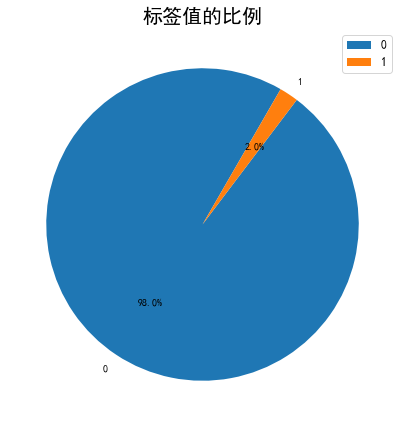

In [16]:
df_test, df_id = split_column(df_test, y="ID")
df_test = df_test.drop(["Y", "is_train"], axis=1)
df_result = model.predict(df_test)
df_id["Label"] = df_result
_ = check_classifier(df_id, col_name="Label")

In [17]:
df_result = model.predict_proba(df_test)

dr_list = []
for dr in df_result:
    dr_list.append(dr[1])

df_id["Label"] = dr_list

_ = df_id.to_csv('Result_{}.csv'.format(str(auc_value)), index=0)

In [18]:
print("** auc_value: {} **".format(auc_value))

** auc_value: 0.9339457615997805 **
